# Important Frequencies Selection

## Import Libraries and seed
Import the necessary libraries for data processing, model building, training, and evaluation. Adding a seed ensures reproducibility by making sure that the random number generation is consistent across different runs.

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


import wandb

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    return seed

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Set seed for reproducibility
seed = set_seed(42)



Using device: cpu


In [4]:
def load_data_from_directory(input_path):
    data_frames = []
    for file in os.listdir(input_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(input_path, file), delimiter=';', header=0)
            data_frames.append(df)
    data = pd.concat(data_frames, ignore_index=True)

    return data

## Preprocessing Data
Define a function to preprocess the data. This includes encoding categorical labels and standardizing the features.

In [32]:
def calculate_averages_and_dispersion(data, data_percentage):
    df = data
    results = []
    for (sample, freq), group in df.groupby(['Sample', 'Frequency (GHz)']):
        window_size = max(1, int(len(group) * data_percentage / 100))
        # print(f"Processing sample: {sample}, frequency: {freq} with window size: {window_size}")
        for start in range(0, len(group), window_size):
            window_data = group.iloc[start:start + window_size]
            mean_values = window_data[['LG (mV)', 'HG (mV)']].mean()
            std_deviation_values = window_data[['LG (mV)', 'HG (mV)']].std()
            results.append({
                'Frequency (GHz)': freq,
                'LG (mV) mean': mean_values['LG (mV)'],
                'HG (mV) mean': mean_values['HG (mV)'],
                'LG (mV) std deviation': std_deviation_values['LG (mV)'],
                'HG (mV) std deviation': std_deviation_values['HG (mV)'],
                # 'Thickness (mm)': window_data['Thickness (mm)'].iloc[0], ## COMMENT
                'Sample': sample,
            })
    results_df = pd.DataFrame(results)
    # results_df.to_csv(output_file, sep=';', index=False)
    # print(f"Processed {input_file} and saved to {output_file}")
    # print(results_df)
    return results_df

## Pivoting Frequency values to columns

In [185]:
def freq_as_variable(df, data_percentage):
    '''Modify df to have Frequency values (100,110,120 and so on) as and input variables in the columns'''

    # Remove Thickness column
    if 'Thickness (mm)' in df.columns:
        df = df.drop(columns=['Thickness (mm)'])

    # 1s window_size 100/27s = 3.7% of the data is used for each window
    df_window = calculate_averages_and_dispersion(df, data_percentage) 

    # Add a unique identifier column to avoid duplicate entries in the index
    df_window['unique_id'] = df_window.groupby(['Sample', 'Frequency (GHz)']).cumcount()

    # Pivot the DataFrame to wide format
    df_pivot = df_window.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')

    # Flatten the MultiIndex columns
    df_pivot.columns = [' '.join(map(str, col)) for col in df_pivot.columns]

    # Drop columns with all NaN values
    df_pivot = df_pivot.dropna(axis=1, how='all')

    # Reset index to make 'Sample' and 'unique_id' columns again
    df_pivot = df_pivot.reset_index()

    # Optional - Sort the columns if needed
    df_pivot = df_pivot.reindex(sorted(df_pivot.columns), axis=1)

    # Remove 'unique_id' column
    df_pivot = df_pivot.drop(columns=['unique_id'])

    return df_pivot

In [144]:
# Load the data from the directory
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test/'
df = load_data_from_directory(input_path)

df = pd.concat([df[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df[['Sample']]], axis=1)

df.head()

,Frequency (GHz),LG (mV),HG (mV),Sample
0,100.0,-7.080942,-0.854611,A1
1,100.0,67.024785,0.244141,A1
2,100.0,124.893178,-1.098776,A1
3,100.0,91.075571,0.000000,A1
4,100.0,48.956174,0.122094,A1


## Sample a test set

In [165]:
# train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sample']) 
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42) 

# stratify=df['Sample'] to keep the same proportion of samples in the train and test set

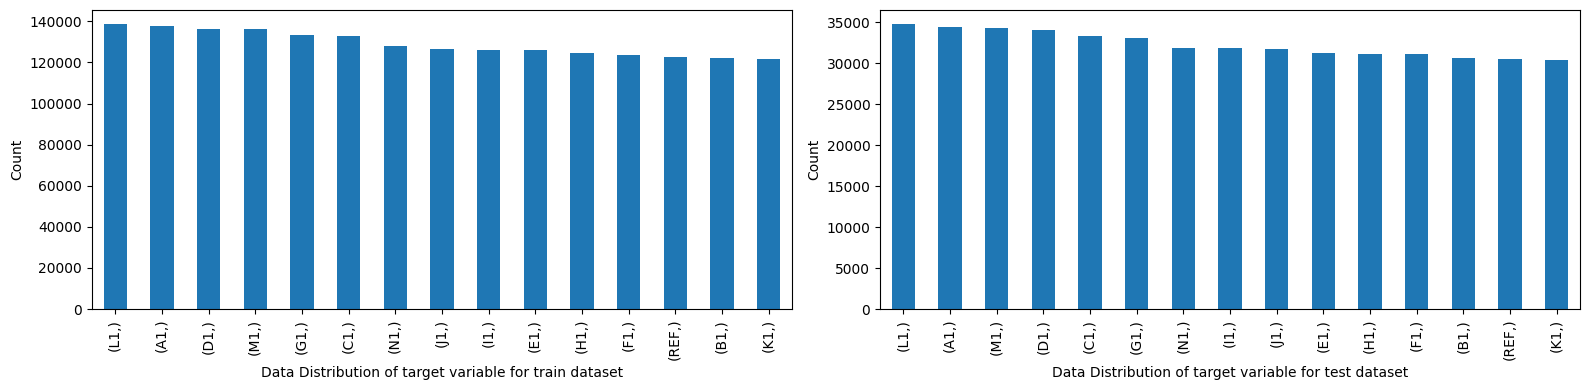

In [166]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Plot train set
train_set[['Sample']].value_counts().plot.bar(ax=ax[0], legend=False)
ax[0].set_xlabel('Data Distribution of target variable for train dataset')
ax[0].set_ylabel('Count')

# Plot test set
test_set[['Sample']].value_counts().plot.bar(ax=ax[1], legend=False)
ax[1].set_xlabel('Data Distribution of target variable for test dataset')
ax[1].set_ylabel('Count')

plt.tight_layout() 
plt.show()

In [159]:
train_ex = train_set.copy()

In [160]:
train_ex.info()
# train_ex.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1936500 entries, 1587912 to 2219110
Data columns (total 4 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Frequency (GHz)  float64
 1   LG (mV)          float64
 2   HG (mV)          float64
 3   Sample           object 
dtypes: float64(3), object(1)
memory usage: 73.9+ MB


In [167]:
train_ex['Sample'].nunique()
train_ex['Frequency (GHz)'].value_counts().sort_index().index

Index([100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, 190.0,
       200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 290.0,
       300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0,
       400.0, 410.0, 420.0, 430.0, 440.0, 450.0, 460.0, 470.0, 480.0, 490.0,
       500.0, 510.0, 520.0, 530.0, 540.0, 550.0, 560.0, 570.0, 580.0, 590.0,
       600.0],
      dtype='float64', name='Frequency (GHz)')

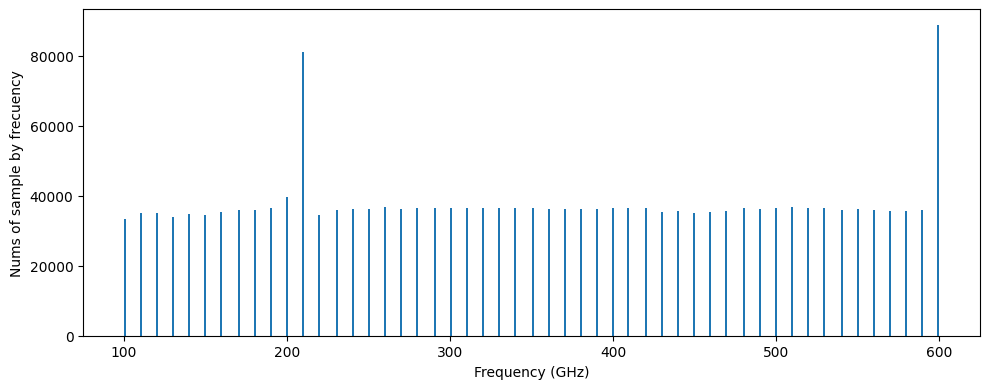

In [169]:
ax = train_ex['Frequency (GHz)'].plot.hist(figsize=(10, 4), bins=408)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Nums of sample by frecuency')
plt.tight_layout()
plt.show()

In [187]:
# Introduce Frequency values as input variables
train_set_test = freq_as_variable(train_set, data_percentage=3.7)
test_set_test = freq_as_variable(test_set, data_percentage=3.7)
train_set_test.head()
test_set_test.head()

#Save the processed data to a CSV file
output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test.csv'
train_set_test.to_csv(output_path, sep = ';', index=False)



## Login in Weights & Biases

In [26]:
###
### SKIP FOR NOW ###
###

%env WANDB_API_KEY=94b4debef3cc9601df4d91995649548f8ab3a097
wandb.login()

# wandb.init(project='PIC-PAPER-01', entity='UC3M', name='RandomForest')
# wandb.watch(rf_model)

env: WANDB_API_KEY=94b4debef3cc9601df4d91995649548f8ab3a097


True

# Prepare Training Data
## Split the data into X and y


In [208]:
# Split the data into X and y
X_train = train_set_test.drop(columns=['Sample'])
y_train = train_set_test['Sample']

X_test = test_set_test.drop(columns=['Sample'])
y_test = test_set_test['Sample']

# Encode the target variable if it's categorical
if y_train.dtype == 'object':
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)

if y_test.dtype == 'object':
    y_test = le.transform(y_test)

# le is the fitted LabelEncoder - Saving Encoder
joblib.dump(le, 'label_encoder.pkl')

print('y_train:', y_train)

# # Convert to PyTorch tensors
# X_groups = torch.tensor(X_groups, dtype=torch.float32)
# y_groups = torch.tensor(y_groups, dtype=torch.long)

y_train: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11

## Prepare new sample for testing (Testing other samples, out of initial dataset)

In [196]:
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_2_plastics/processed/test/'
df_new_sample = load_data_from_directory(input_path)
df_new_sample = pd.concat([df_new_sample[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df_new_sample[['Sample']]], axis=1)

# Add .0 on every Frequency column value to match the format of the training data
df_new_sample['Frequency (GHz)'] = df_new_sample['Frequency (GHz)'].astype(str) + '.0'
print('X_new_sample:', df_new_sample)

df_new_sample = freq_as_variable(df_new_sample, data_percentage=0.22) # 0.22

X_new_sample = df_new_sample.drop(columns=['Sample'])
y_new_sample = df_new_sample['Sample']

if y_new_sample.dtype == 'object':
    y_new_sample = le.transform(y_new_sample)

print('X_new_sample:', X_new_sample)
print('y_new_sample:', y_new_sample)


X_new_sample:       Frequency (GHz)    LG (mV)    HG (mV) Sample
0               100.0  31.375900  -0.610423     E1
1               100.0  27.469173  -0.244117     E1
2               100.0  46.758637  -0.244164     E1
3               100.0  93.883531   0.488353     E1
4               100.0  82.163350  -0.488377     E1
...               ...        ...        ...    ...
70927           600.0   0.610426  36.381394     E1
70928           600.0   0.122085   9.400561     E1
70929           600.0   0.732511  32.596752     E1
70930           600.0  -0.122085  29.422536     E1
70931           600.0   0.000000  13.307288     E1

[70932 rows x 4 columns]


KeyboardInterrupt: 

## Train Model

Accuracy: 0.9726027397260274
Precision: 0.9767041013616357
Recall: 0.9726027397260274
F1: 0.9734397799927299
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        29
           1       1.00      0.97      0.98        29
           2       1.00      1.00      1.00        29
           3       1.00      0.97      0.98        29
           4       0.78      1.00      0.88        29
           5       0.97      1.00      0.98        29
           6       1.00      0.97      0.98        29
           7       1.00      0.97      0.98        29
           8       0.97      0.97      0.97        29
           9       0.97      1.00      0.98        29
          10       1.00      0.91      0.95        32
          11       1.00      0.97      0.98        29
          12       1.00      1.00      1.00        29
          13       1.00      0.97      0.98        29
          14       1.00      0.97      0.98        29

    accuracy             

Text(0.5, 0, 'Importance')

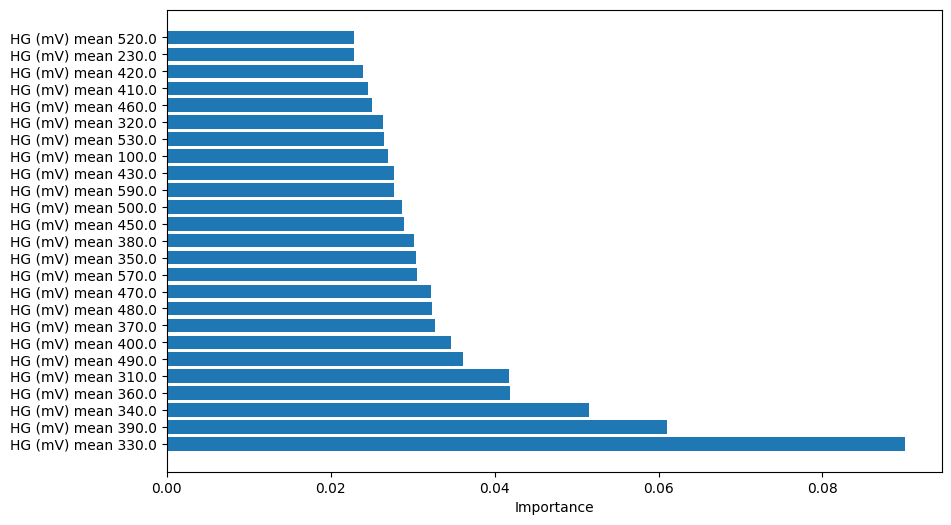

In [ ]:
# Model Parameters
input_size = X_train.shape[1]
output_size = len(np.unique(y_train))
seed = set_seed(42)

# print(f'input_size: {input_size}, output_size: {output_size}')
# print(X_train, y_train)

# Reduce the number of features to the first 50
X_train = X_train.iloc[:, :51]
X_test = X_test.iloc[:, :51]


# Define Random Forest model
rf_model = RandomForestClassifier(n_estimators=10, criterion= 'gini' , random_state=seed)

# # Define Naive-Bayes model
# nb_model = GaussianNB()

# # Define Logistic Regression model
# lr_model = LogisticRegression(max_iter=1000, random_state = seed)


# Train model using wandb for metrics
# TBD 

# Train the model
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# y_pred = rf_model.predict(X_new_sample)
# y_test_original = y_test.copy()
# y_test = y_new_sample

# # Create a DataFrame to compare
# df_comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# print(df_comparison.head(10))

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Classification report
print(classification_report(y_test, y_pred), )

# Predictions made per class with its label encoded value
print(Counter(y_pred))

# Feature importance (Find 10 most important variables with its name and importance value)
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)
print(feature_importances_df.head(25))
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'][:25], feature_importances_df['Importance'][:25])
plt.xlabel('Importance')


# Log metrics wandb
# wandb.log({"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1})






## Confusion Matrix

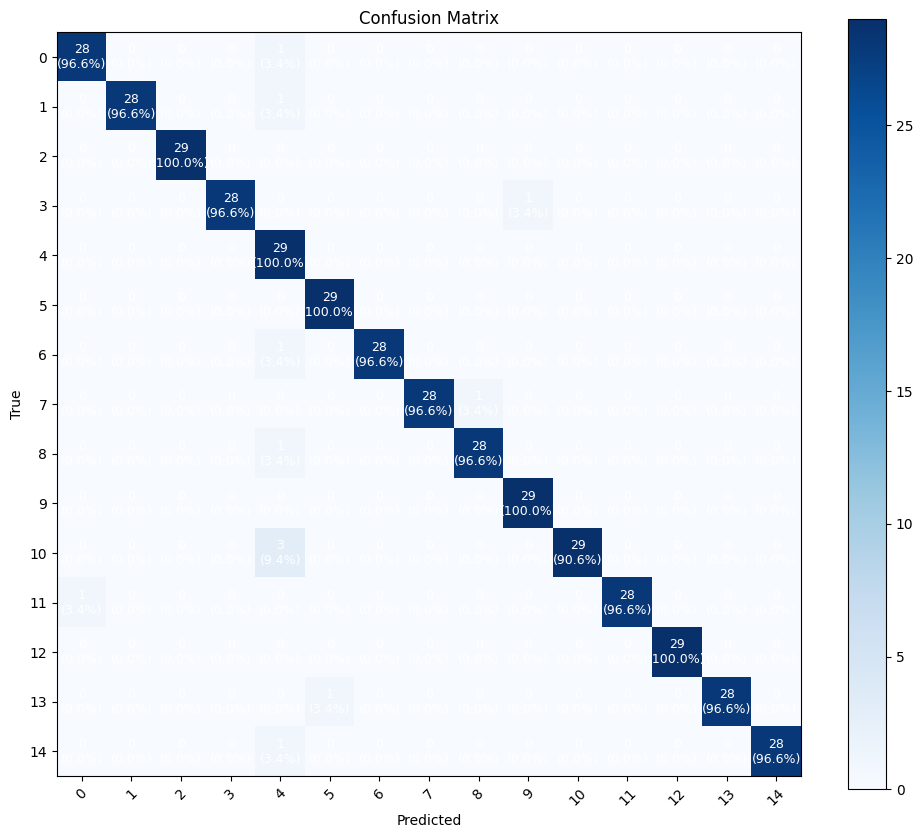

In [210]:
# Confusion matrix with matplotlib
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(np.unique(y_test))), np.unique(y_test), rotation=45)
plt.yticks(np.arange(len(np.unique(y_test))), np.unique(y_test))
plt.ylabel('True')
plt.xlabel('Predicted')
for i in range(len(np.unique(y_test))):
    for j in range(len(np.unique(y_test))):
        plt.text(j, i, f'{conf_matrix[i, j]}\n({conf_matrix[i, j] / np.sum(conf_matrix, axis=1)[i] * 100:.1f}%)',
                horizontalalignment="center",
                verticalalignment="center",
                fontsize=9,
                ha='center', va='center', color='white')
plt.show()

## Load and preprocess Other Test Data (Experiment 2)

In [ ]:
#TBD

In [ ]:
# ## Confusion Matrix
# conf_matrix = confusion_matrix(le.inverse_transform(y_test.cpu().numpy()), predicted_labels, labels=le.classes_)

# # Confusion matrix with matplotlib
# plt.figure(figsize=(12, 10))
# plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.colorbar()
# tick_marks = np.arange(len(le.classes_))
# plt.xticks(tick_marks, le.classes_, rotation=45)
# plt.yticks(tick_marks, le.classes_)

# # Normalize the confusion matrix
# conf_matrix_normalized = np.nan_to_num(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis])

# # Print the normalized values inside the matrix as percentages
# thresh = conf_matrix.max() / 2.
# for i, j in np.ndindex(conf_matrix.shape):
#     plt.text(j, i, f"{conf_matrix[i, j]}\n ({conf_matrix_normalized[i, j] * 100:.1f}%)",
#              horizontalalignment="center",
#              verticalalignment="center",
#              fontsize=9,
#              color="white" if conf_matrix[i, j] > thresh else "black")

# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.tight_layout()

## Feature Importance TBD

## Labels

| Original Label | Encoded Value |
|----------------|---------------|
| A1             | 0             |
| B1             | 1             |
| C1             | 2             |
| D1             | 3             |
| E1             | 4             |
| F1             | 5             |
| G1             | 6             |
| H1             | 7             |
| I1             | 8             |
| J1             | 9             |
| K1             | 10            |
| L1             | 11            |
| M1             | 12            |
| N1             | 13            |
| REF            | 14            |